# **시계열**

## **1. 모듈 불러오기**

In [1]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import seaborn as sns

%matplotlib inline

import itertools

In [35]:
!pip install statsmodels==0.11.1

  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\anjui\anaconda3\python.exe' 'C:\Users\anjui\AppData\Local\Temp\pip-standalone-pip-jmspcal8\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\anjui\AppData\Local\Temp\pip-build-env-u_vxgbtq\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel 'cython>=0.29.14' 'numpy==1.14.5; python_version=='"'"'3.5'"'"'' 'numpy==1.14.5; python_version=='"'"'3.6'"'"'' 'numpy==1.16.1; python_version=='"'"'3.7'"'"'' 'numpy==1.17.5; python_version>='"'"'3.8'"'"'' 'scipy>=1.0'
       cwd: None
  Complete output (590 lines):
  Ignoring numpy: markers 'python_version == "3.5"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
    Using cached scipy-1.7.1-cp39-cp39-win_amd64.whl (33.8 MB)
    ERROR: Command

## **2. 데이터 불러오기**

In [2]:
data = pd.read_csv('2주차_시계열_연관분석/AirPassengers.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data = data.rename(columns = {'Month':'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## **3. BOX-Jenkins ARIMA Procedure**


### 3.1 Data preprocessing

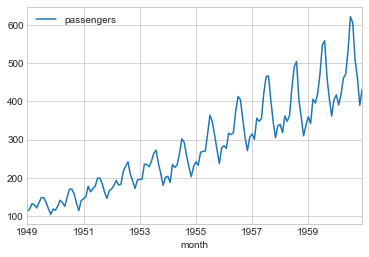

In [6]:
fig = data.plot()

In [7]:
sm.__version__

'0.13.0'

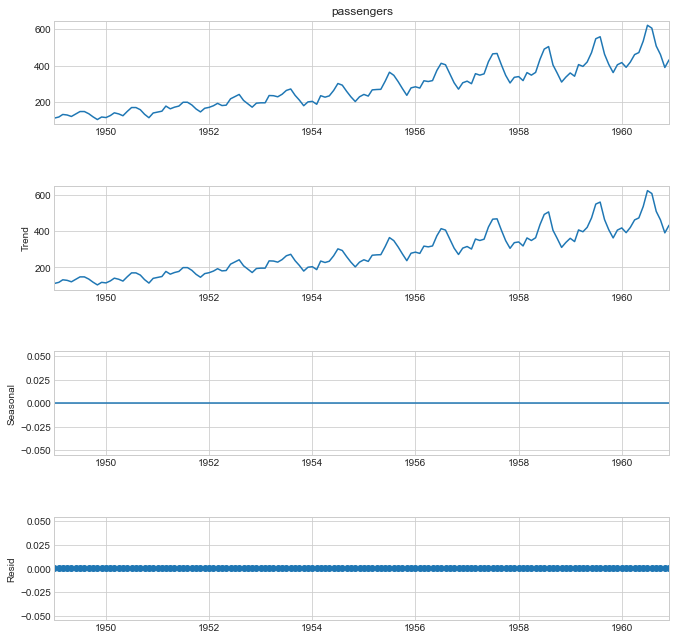

In [10]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

#sm.__version__ '0.10.1'
#decompostion = sm.tsa.seasonal_decompose(data['passengers'], model = 'additive', freq =1)
#sm.__version__ '0.13.0'
decompostion = sm.tsa.seasonal_decompose(data['passengers'], model = 'additive', period =1)

fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

# 아래 그래프를 데이터로 추출 https://dodonam.tistory.com/89
# decompostion.observed
# decompostion.trend
# decompostion.seasonal
# decompostion.resid

### 3.2 identify Model to be Tentatively Entertained

In [11]:
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle = False)

time : 0.03699994087219238


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


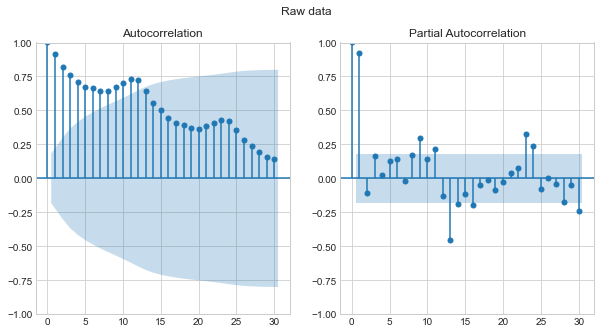

In [12]:
# ACF, PACF

import time
start = time.time()  # 시작 시간 저장

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw data')
sm.graphics.tsa.plot_acf(train_data['passengers'], lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data['passengers'], lags = 30, ax = ax[1])
print("time :", time.time() - start)

In [13]:
# Dickey-Fuller test
# p-value가 0.05보다 크면 비정상성

result = adfuller(train_data['passengers'])
print('p-value : ', result[1])

print('-------------------------------------------------------------------------------------------------------')

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items(): 
    dfoutput['Critical Value (%s)'%key] = value
pvalue = result[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

p-value :  0.9170517285875908
-------------------------------------------------------------------------------------------------------
p-value = 0.9171. The series is likely non-stationary.
Test Statistic                  -0.356889
p-value                          0.917052
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


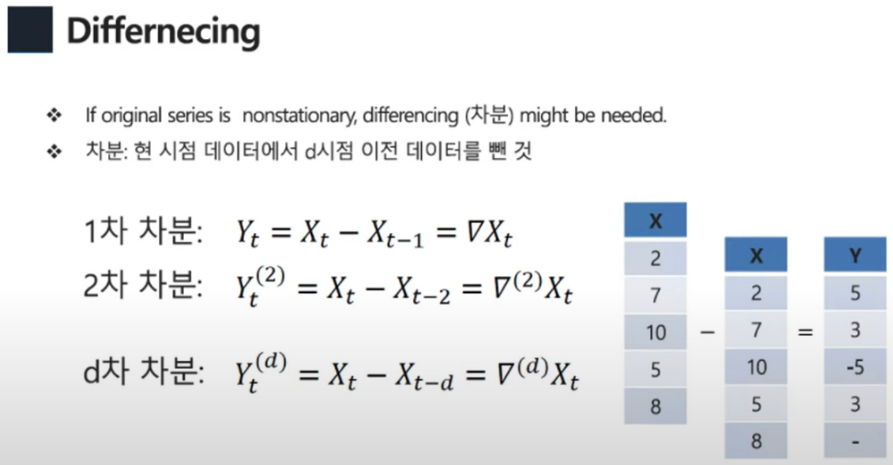

In [14]:
# Differencing 차분

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff() #default가 1차 차분
diff_train_data = diff_train_data.dropna() # 차분 하면 마지막 값이 결측치
print('------ Raw data -----')
print(train_data)
print('------ Differenced data -----')
print(diff_train_data)

------ Raw data -----
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
------ Differenced data -----
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


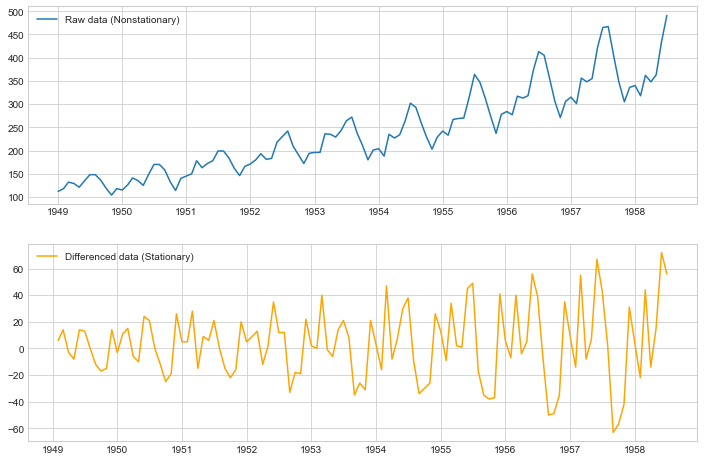

In [15]:
# Differenced data plot

plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw data (Nonstationary)'])

plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced data (Stationary)'])

plt.show()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


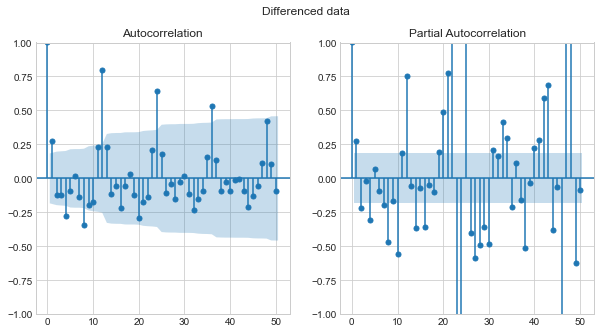

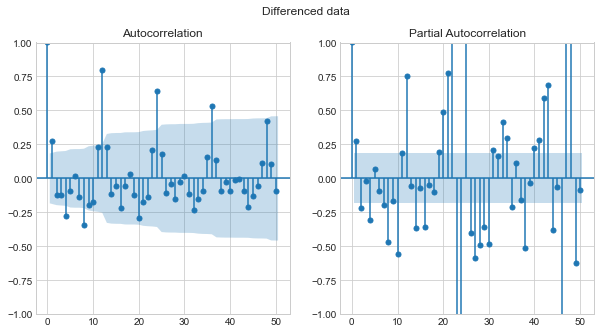

In [16]:
# ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Differenced data')
sm.graphics.tsa.plot_acf(diff_train_data, lags = 50, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data, lags = 50, ax = ax[1])

In [17]:
# Dickey-Fuller test
# p-value가 0.05보다 크면 비정상성

result = adfuller(diff_train_data)
print('p-value : ', result[1])

print('-------------------------------------------------------------------------------------------------------')

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items(): 
    dfoutput['Critical Value (%s)'%key] = value
pvalue = result[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

p-value :  0.10612609999673256
-------------------------------------------------------------------------------------------------------
p-value = 0.1061. The series is likely non-stationary.
Test Statistic                  -2.539635
p-value                          0.106126
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


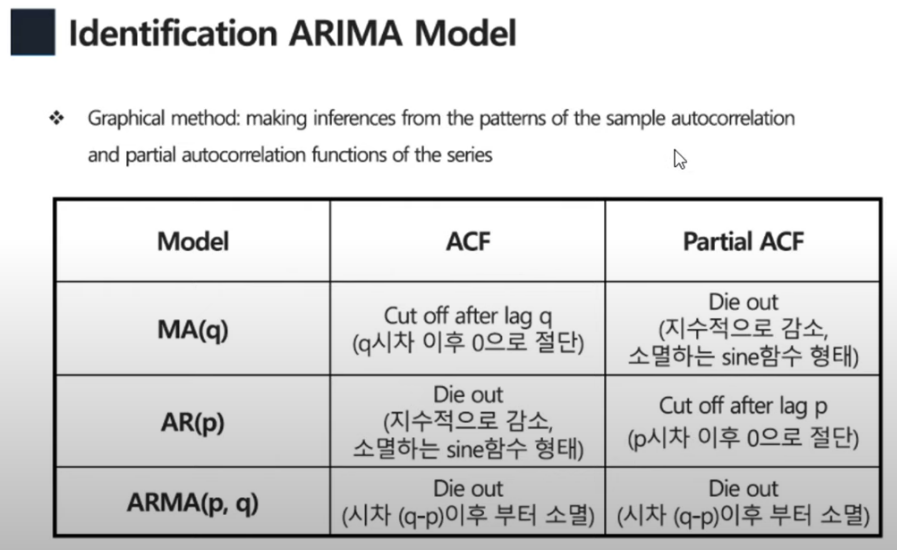

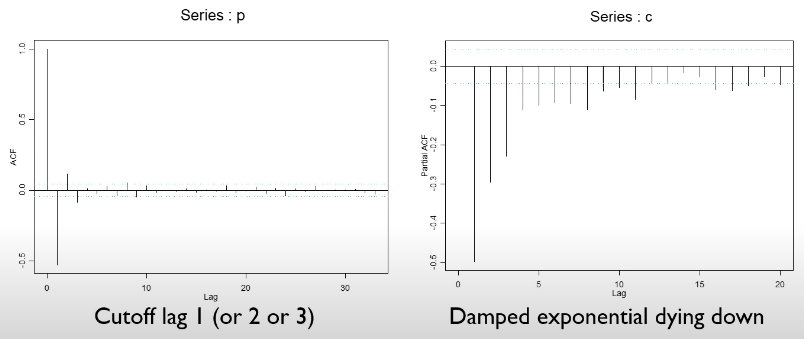

어떤 모델을 시범적으로 해볼지에 대해 Graphical 방법으로 찾아보기

ACF, PACF 그래프를 보고 처음에 AR 할지 MA 할지 ARMA 할지를 결정(주관적임)

ARIMA(p,d,q) = ARIMA(0,1,1), ARIMA(0,1,2)

### 3.3 Estimate Parameters

In [23]:
# ARIMA model fitiing 
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.

# sm.__version__ '0.13.0'
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data['passengers'], order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Sat, 06 Nov 2021   AIC                           1068.536
Time:                        01:48:38   BIC                           1074.008
Sample:                    01-01-1949   HQIC                          1070.757
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model_fit.plot_predict()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

### 3.4.1 Diagnosis Check - ARIMA

In [25]:
# Parameter search

print('Examples of parameter combinations for Seadonal ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(q, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data['passengers'], order=(i))
    model_fit = model.fit()
    print('ARIMA:', i, '>> AIC :', round(model_fit.aic,2))
    aic.append(round(model_fit.aic,2))



Examples of parameter combinations for Seadonal ARIMA
ARIMA: (0, 1, 0) >> AIC : 1076.27
ARIMA: (0, 1, 1) >> AIC : 1063.65
ARIMA: (0, 1, 2) >> AIC : 1060.69
ARIMA: (1, 1, 0) >> AIC : 1068.54
ARIMA: (1, 1, 1) >> AIC : 1058.25
ARIMA: (1, 1, 2) >> AIC : 1057.33


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency informa

ARIMA: (2, 1, 0) >> AIC : 1065.64
ARIMA: (2, 1, 1) >> AIC : 1058.65
ARIMA: (2, 1, 2) >> AIC : 1057.52


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency informa

In [26]:
# Search optimal parameters
# List comprehension

optimal = [(pdq[i], j ) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), 1057.33)]

In [27]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
#model_opt = ARIMA(train_data.values, order=(2,1,1))

model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Sat, 06 Nov 2021   AIC                           1057.328
Time:                        01:48:50   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.1 use Model to Forecast - ARIMA

In [28]:
# predict value, predict interval 제공
# forecast method, 들어가는 인수는 이후로 얼마나 예측할지 넣어줘야 함
# predict interval은 (start, end index) 값으로 도출

# forecast 는 3개의 array를 튜플로 묶은 데이터를 반환한다. 
# 첫번째 array 는 점 예측값이고 두번째는 upper bound, 세번째는 lower bound 이다. 
pred = model_opt_fit.forecast(len(test_data))
pred_value = pred[0]

pred_ub = pred[2][:,0]
pred_lb = pred[2][:,1]
pred_index = list(test_data.index)
r2 = r2_score(test_data, pred_value)

IndexError: invalid index to scalar variable.

NameError: name 'pred_index' is not defined

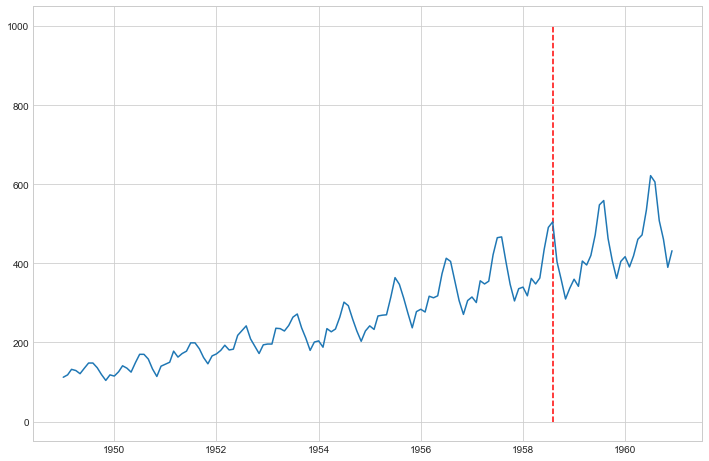

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(data.index, data['passengers'])

# 예측 시작 지점 
# 1958-08-01은 datetime 형태인데 그냥 집어넣으면 에러 뜸, pd.to_datetime으로 다시
ax.vlines(pd.to_datetime('1958-08-01'), 0, 1000, linestyle = '--', color='r', 
         label='Start of Forecast');
ax.plot(pred_index, pred_value, label = 'prediction',color='orange')

# lower bound, upper bound 색칠
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1,
               label='0.95 prediciton interval')

ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score:{round(r2,2)})')
plt.show()

### 3.4.2 Diagnosis Check - SARIMA

In [30]:
print('Examples of parameter combinations of SARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print(pdq)
print(seasonal_pdq)

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try: 
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA parameter : {i} {j} >> AIC: {round(model_fit.aic,2)}')
            params.append((i,j))
            aic.append(round(model_fit.aic,2))
        except:
            continue
        # try, except 구문 , try 중 에러 나면 except 수행

Examples of parameter combinations of SARIMA...
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
[(0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]
SARIMA parameter : (0, 1, 0) (0, 1, 0, 12) >> AIC: 757.83
SARIMA parameter : (0, 1, 0) (0, 1, 1, 12) >> AIC: 756.99
SARIMA parameter : (0, 1, 0) (0, 1, 2, 12) >> AIC: 758.83
SARIMA parameter : (0, 1, 0) (1, 1, 0, 12) >> AIC: 756.96
SARIMA parameter : (0, 1, 0) (1, 1, 1, 12) >> AIC: 758.92
SARIMA parameter : (0, 1, 0) (1, 1, 2, 12) >> AIC: 754.42
SARIMA parameter : (0, 1, 0) (2, 1, 0, 12) >> AIC: 758.87
SARIMA parameter : (0, 1, 0) (2, 1, 1, 12) >> AIC: 760.73


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (0, 1, 0) (2, 1, 2, 12) >> AIC: 754.87
SARIMA parameter : (0, 1, 1) (0, 1, 0, 12) >> AIC: 756.01
SARIMA parameter : (0, 1, 1) (0, 1, 1, 12) >> AIC: 756.38
SARIMA parameter : (0, 1, 1) (0, 1, 2, 12) >> AIC: 757.65
SARIMA parameter : (0, 1, 1) (1, 1, 0, 12) >> AIC: 756.17
SARIMA parameter : (0, 1, 1) (1, 1, 1, 12) >> AIC: 758.11


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (0, 1, 1) (1, 1, 2, 12) >> AIC: 751.73
SARIMA parameter : (0, 1, 1) (2, 1, 0, 12) >> AIC: 757.99
SARIMA parameter : (0, 1, 1) (2, 1, 1, 12) >> AIC: 753.78


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (0, 1, 1) (2, 1, 2, 12) >> AIC: 85.55
SARIMA parameter : (0, 1, 2) (0, 1, 0, 12) >> AIC: 757.78
SARIMA parameter : (0, 1, 2) (0, 1, 1, 12) >> AIC: 758.04
SARIMA parameter : (0, 1, 2) (0, 1, 2, 12) >> AIC: 759.28
SARIMA parameter : (0, 1, 2) (1, 1, 0, 12) >> AIC: 757.81
SARIMA parameter : (0, 1, 2) (1, 1, 1, 12) >> AIC: 759.75
SARIMA parameter : (0, 1, 2) (1, 1, 2, 12) >> AIC: 753.5
SARIMA parameter : (0, 1, 2) (2, 1, 0, 12) >> AIC: 759.64


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (0, 1, 2) (2, 1, 1, 12) >> AIC: 755.49


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (0, 1, 2) (2, 1, 2, 12) >> AIC: 761.98
SARIMA parameter : (1, 1, 0) (0, 1, 0, 12) >> AIC: 755.5
SARIMA parameter : (1, 1, 0) (0, 1, 1, 12) >> AIC: 755.98
SARIMA parameter : (1, 1, 0) (0, 1, 2, 12) >> AIC: 757.1
SARIMA parameter : (1, 1, 0) (1, 1, 0, 12) >> AIC: 755.75
SARIMA parameter : (1, 1, 0) (1, 1, 1, 12) >> AIC: 757.65
SARIMA parameter : (1, 1, 0) (1, 1, 2, 12) >> AIC: 751.15
SARIMA parameter : (1, 1, 0) (2, 1, 0, 12) >> AIC: 757.45
SARIMA parameter : (1, 1, 0) (2, 1, 1, 12) >> AIC: 752.99


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (1, 1, 0) (2, 1, 2, 12) >> AIC: 760.12
SARIMA parameter : (1, 1, 1) (0, 1, 0, 12) >> AIC: 756.02
SARIMA parameter : (1, 1, 1) (0, 1, 1, 12) >> AIC: 756.63
SARIMA parameter : (1, 1, 1) (0, 1, 2, 12) >> AIC: 757.75
SARIMA parameter : (1, 1, 1) (1, 1, 0, 12) >> AIC: 756.41
SARIMA parameter : (1, 1, 1) (1, 1, 1, 12) >> AIC: 758.26


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (1, 1, 1) (1, 1, 2, 12) >> AIC: 752.53
SARIMA parameter : (1, 1, 1) (2, 1, 0, 12) >> AIC: 758.03


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (1, 1, 1) (2, 1, 1, 12) >> AIC: 754.16


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (1, 1, 1) (2, 1, 2, 12) >> AIC: 88.74
SARIMA parameter : (1, 1, 2) (0, 1, 0, 12) >> AIC: 757.92
SARIMA parameter : (1, 1, 2) (0, 1, 1, 12) >> AIC: 758.44
SARIMA parameter : (1, 1, 2) (0, 1, 2, 12) >> AIC: 759.63
SARIMA parameter : (1, 1, 2) (1, 1, 0, 12) >> AIC: 758.22
SARIMA parameter : (1, 1, 2) (1, 1, 1, 12) >> AIC: 760.1
SARIMA parameter : (1, 1, 2) (1, 1, 2, 12) >> AIC: 754.53
SARIMA parameter : (1, 1, 2) (2, 1, 0, 12) >> AIC: 759.92
SARIMA parameter : (1, 1, 2) (2, 1, 1, 12) >> AIC: 756.16


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (1, 1, 2) (2, 1, 2, 12) >> AIC: 763.35
SARIMA parameter : (2, 1, 0) (0, 1, 0, 12) >> AIC: 756.77
SARIMA parameter : (2, 1, 0) (0, 1, 1, 12) >> AIC: 757.23
SARIMA parameter : (2, 1, 0) (0, 1, 2, 12) >> AIC: 758.31
SARIMA parameter : (2, 1, 0) (1, 1, 0, 12) >> AIC: 756.98
SARIMA parameter : (2, 1, 0) (1, 1, 1, 12) >> AIC: 758.86


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (2, 1, 0) (1, 1, 2, 12) >> AIC: 752.77
SARIMA parameter : (2, 1, 0) (2, 1, 0, 12) >> AIC: 758.65
SARIMA parameter : (2, 1, 0) (2, 1, 1, 12) >> AIC: 754.5


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA parameter : (2, 1, 0) (2, 1, 2, 12) >> AIC: 762.49
SARIMA parameter : (2, 1, 1) (0, 1, 0, 12) >> AIC: 757.98


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA parameter : (2, 1, 1) (0, 1, 1, 12) >> AIC: 758.54


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA parameter : (2, 1, 1) (0, 1, 2, 12) >> AIC: 759.69
SARIMA parameter : (2, 1, 1) (1, 1, 0, 12) >> AIC: 758.31


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA parameter : (2, 1, 1) (1, 1, 1, 12) >> AIC: 760.18


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packa

SARIMA parameter : (2, 1, 1) (1, 1, 2, 12) >> AIC: 754.53
SARIMA parameter : (2, 1, 1) (2, 1, 0, 12) >> AIC: 759.98


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anjui\anaconda3\lib\site-packa

SARIMA parameter : (2, 1, 1) (2, 1, 1, 12) >> AIC: 756.17


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA parameter : (2, 1, 1) (2, 1, 2, 12) >> AIC: 762.58
SARIMA parameter : (2, 1, 2) (0, 1, 0, 12) >> AIC: 755.2
SARIMA parameter : (2, 1, 2) (0, 1, 1, 12) >> AIC: 755.99
SARIMA parameter : (2, 1, 2) (0, 1, 2, 12) >> AIC: 759.77
SARIMA parameter : (2, 1, 2) (1, 1, 0, 12) >> AIC: 755.82
SARIMA parameter : (2, 1, 2) (1, 1, 1, 12) >> AIC: 757.71
SARIMA parameter : (2, 1, 2) (1, 1, 2, 12) >> AIC: 752.34
SARIMA parameter : (2, 1, 2) (2, 1, 0, 12) >> AIC: 757.56
SARIMA parameter : (2, 1, 2) (2, 1, 1, 12) >> AIC: 753.96
SARIMA parameter : (2, 1, 2) (2, 1, 2, 12) >> AIC: 761.43


In [31]:
print(min(aic))
# ctrl+F SARIMA parameter : (1, 1, 0) (1, 1, 2, 12) >> AIC: 751.15

optimal = [(params[i], j) for i, j in enumerate(aic) if j==min(aic)]
optimal

85.55


[(((0, 1, 1), (2, 1, 2, 12)), 85.55)]

In [32]:
model_opt = SARIMAX(train_data, order = (1,1,0), seasonal_order = (1,1,2,12))

#model_opt = SARIMAX(train_data, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.574
Date:                                 Sat, 06 Nov 2021   AIC                            751.149
Time:                                         01:49:53   BIC                            764.274
Sample:                                     01-01-1949   HQIC                           756.463
                                          - 07-01-1958                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2354      0.093     -2.530      0.011      -0.418      -0.053
ar.S.L12       0.9984      0.192      5.207      0.000       0.623       1.374
ma.S.L12      -1.3676      2.343     -0.584      0.559      -5.960       3.225
ma.S.L24       0.3933      0.830      0.474      0.636      -1.234       2.020
sigma2        69.9992    151.369      0.462      0.644    -226.679     366.678
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.89   Prob(JB):                         0.25
Heteroskedasticity (H):               1.09   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.2 use Model to Forecast - SARIMA

In [ ]:
# ARIMA와 코드가 살짝 다름(forcast 대신 get_forcast)
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int().iloc[:,0]
predicted_lb = prediction.conf_int().iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(data.index, data)
ax.vlines(pd.to_datetime('1958-08-01'), 0,700, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(predict_index, predicted_value, label='prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k',
               alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0], optimal[0][0][1]} prediction results (r2score: {round(r2,2)})')
plt.show()

### 3.4.3 Diagnosis Check - auto arima

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

# Parameter search
# trace 는 결과값을 print 해주는 인자
# 이전에는 AIC가 가장 작은 경우의 파라미터를 다시 넣어서 피팅했는데
# auto_arima 는 자동으로 가장 적합한 파라미터를 학습시킴

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, 
                             max_p = 3, max_q = 3, m=12, seasonal=True,
                             d=1, D=1, max_P=3, max_Q = 3,
                             trace=True,
                             error_action = 'ignore',
                             suppress_warnings = True,
                             stepwise=False)

In [ ]:
auto_arima_model.summary()

### 3.5.3 use Model to Forecast - auto_arima


In [ ]:
# predict를 쓴다.
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
print(prediction)

In [ ]:
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predicted_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize= (12,6))
ax.plot(data.index, data)
ax.vlines(pd.to_datetime('1958-08-01'), 0, 700, linestyle='--',
         color='r', label='Start of Forecast')
ax.plot(predicted_index, predicted_value, label='Prediction')
ax.fill_between(predicted_index, predicted_ub, predicted_lb,
               color='k', alpha=1, label='interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA({auto_arima_model.order, auto_arima_model.seasonal_order}) prediction results: {round(r2,2)}(r2 score)' )

## 출처

실습 자료
1. https://www.youtube.com/watch?v=rdR2fNDq6v0
2. https://www.kaggle.com/shutupandsquat/air-passengers-prediction-korean#3.-Box-Jenkins-ARIMA-Procedure
3. https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

이론 자료
1. https://www.youtube.com/watch?v=ma_L2YRWMHI
2. https://blog.naver.com/nywoo19/221600142327
3. https://otexts.com/fppkr/stationarity.html